# Parte II - Extracción de las series de tiempo a través de Yahoo Finance y arquitectura LSTM

### Carga de los datos y tratamiento

In [1]:
import torch
import pandas as pd
import numpy as np

torch.__version__

'2.3.1+cu121'

In [2]:
torch.manual_seed(77)

In [3]:
import yfinance as yf

data = yf.download('TSLA', start='2019-01-01', end='2024-11-01', interval='1d')

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2019-01-02 00:00:00+00:00,20.674667,20.674667,21.008667,19.920000,20.406668,174879000
2019-01-03 00:00:00+00:00,20.024000,20.024000,20.626667,19.825333,20.466667,104478000
2019-01-04 00:00:00+00:00,21.179333,21.179333,21.200001,20.181999,20.400000,110911500
2019-01-07 00:00:00+00:00,22.330667,22.330667,22.449333,21.183332,21.448000,113268000
2019-01-08 00:00:00+00:00,22.356667,22.356667,22.934000,21.801332,22.797333,105127500


In [4]:
data.shape

(1469, 6)

### Visualización de los datos

<Axes: title={'center': 'Adj Price TESLA'}, xlabel='Time', ylabel='Price'>

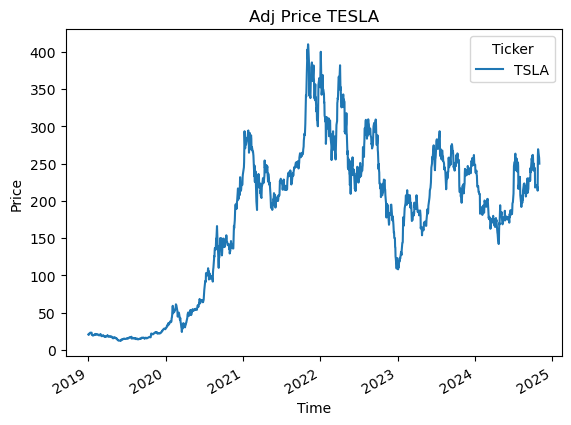

In [5]:
import matplotlib.pyplot as plt

data_adj = data['Adj Close'].dropna()

data_adj.plot(title='Adj Price TESLA', xlabel='Time', ylabel = 'Price')

- Para obtener mejores resultados debemos deshacernos de la estacionalidad,  del ruido y normalizar nuestras series de tiempo. Primero evaluamos tres maneras de eliminar la estacionalidad a partir del primedio de los residuales. Entre más alejado sea de 0, será el método que más nos convenga.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

des_add = seasonal_decompose(data_adj, model='additive', period=365)
des_mult = seasonal_decompose(data_adj, model='multiplicative', period=365)
des_stl = STL(data_adj, period = 365).fit()

In [7]:
des_add.resid.mean(), des_mult.resid.mean(), des_stl.resid.mean()

(2.3010124391920863, 0.9670052173817174, 1.5954741079891235)

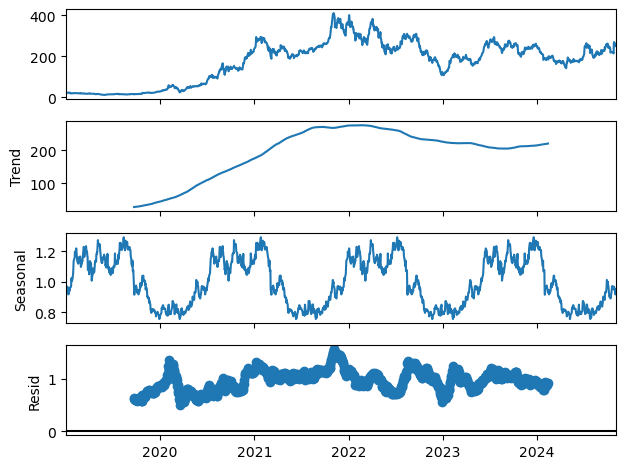

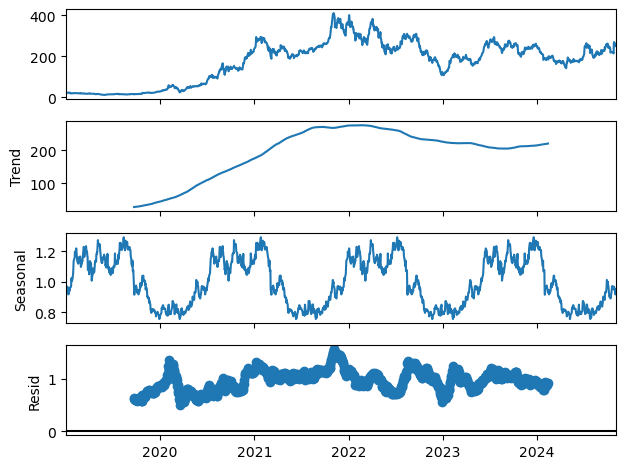

In [8]:
des_mult.plot()

- Una vez analizados los promedios residuales nos percatamos que el promedio más bajo es el de la descomposición multiplicativa, por lo que elegiremos este

In [9]:
estacionalidad = des_mult.seasonal

In [10]:
data_clean = data_adj['TSLA'] - estacionalidad

<Axes: xlabel='Date'>

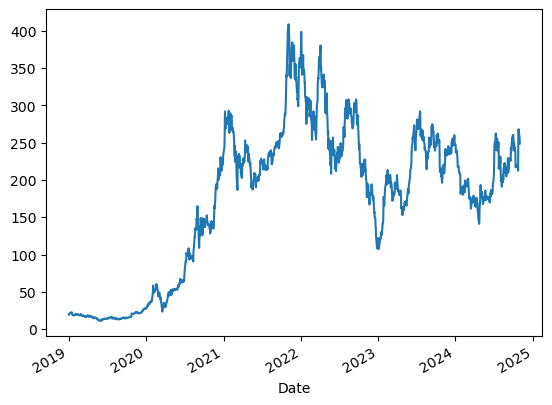

In [11]:
data_clean.plot()

- División entre datos de entrenamiento y datos de evaluación

In [12]:
train_size = int(len(data_clean) * 0.67)
test_size = len(data_clean) - train_size

train_data, test_data = data_clean[:train_size], data_clean[train_size:]

In [13]:
len(train_data), len(test_data)

(984, 485)

### Pipeline

- Ventanas de predicción para pedirle al modelo que prediga el siguiente dato.

**Window Time**
$$t - w$$

**Window Time Predict**
$$t + 1

In [14]:
def window_time(dataset, lookback):

    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [15]:
lookback = 1
X_train, y_train = window_time(train_data, lookback)
X_test, y_test = window_time(test_data, lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([983, 1]) torch.Size([983, 1])
torch.Size([484, 1]) torch.Size([484, 1])


C:\Users\aleja\AppData\Local\Temp\ipykernel_14884\2988494864.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(X), torch.tensor(y)


In [41]:
X_train, y_train = X_train.float(), y_train.float()
X_test, y_test = X_test.float(), y_test.float()

### Modelo - Arquitectura LSTM

In [97]:
import torch.nn as nn
from torch import optim
import time
import torch.utils.data as data

In [98]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, 
                        hidden_size=50, 
                        num_layers=1, 
                        batch_first=True)
        self.fc1 = nn.Linear(50, 1)
        self.relu1 = nn.ReLU()
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x)
        x = self.relu1(x)

        return x

### Entrenamiento

In [99]:
model = LSTM()
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [100]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for x_serie, y_serie in train_loader:
        x_serie, y_serie = x_serie.to(device), y_serie.to(device)
        x_serie, y_serie = x_serie.float(), y_serie.float()
        
        y_pred = model(x_serie)

        loss = loss_fn(y_pred, y_serie)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [101]:
def test(model, device, x_train, y_train, x_test, y_test):
    with torch.no_grad():
        model.eval()
        x_train, y_train, x_test, y_test = x_train.to(device), y_train.to(device), x_test.to(device), y_test.to(device)
        y_pred = model(x_train)
        y_pred = y_pred.squeeze()
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(x_test)
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
        
    print('Train RMSE: %.4f, test RMSE: %.4f' % (train_rmse, test_rmse))

In [102]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [103]:
model.to(device)

lstm_optimizer = optim.Adam(model.parameters(), lr=0.001)

In [104]:
epochs = 10

for epoch in range(epochs):
    train(model, device, loader, lstm_optimizer, epoch)
    test(model, device, X_train, y_train, X_test, y_test)


Time for epoch 0 is 0.3881 sec Train loss: 37914.5526
Train RMSE: 191.3452, test RMSE: 203.9178

Time for epoch 1 is 0.3524 sec Train loss: 35551.0239
Train RMSE: 185.1063, test RMSE: 195.9861

Time for epoch 2 is 0.3499 sec Train loss: 33512.3447
Train RMSE: 180.0592, test RMSE: 189.5121

Time for epoch 3 is 0.3287 sec Train loss: 31849.7106
Train RMSE: 177.0703, test RMSE: 183.6314

Time for epoch 4 is 0.3271 sec Train loss: 30276.7292
Train RMSE: 173.9071, test RMSE: 177.7266

Time for epoch 5 is 0.3120 sec Train loss: 28775.7024
Train RMSE: 170.9397, test RMSE: 172.0446

Time for epoch 6 is 0.3266 sec Train loss: 27429.1426
Train RMSE: 168.0087, test RMSE: 166.4515

Time for epoch 7 is 0.3015 sec Train loss: 26096.7162
Train RMSE: 165.5920, test RMSE: 161.0092

Time for epoch 8 is 0.3052 sec Train loss: 24772.3001
Train RMSE: 162.9138, test RMSE: 155.6701

Time for epoch 9 is 0.3121 sec Train loss: 23562.6462
Train RMSE: 161.4660, test RMSE: 150.4403
